# **Projeto de Análise de COVID-19 no Brasil - Pipeline Completo**

## **1. Configuração do Ambiente e Bibliotecas**
**Descrição:**

- Nesta primeira etapa, vamos configurar nosso ambiente de trabalho. Isso envolve importar as bibliotecas essenciais que usaremos em todo o projeto (pandas para manipulação de dados, glob para encontrar arquivos) e conectar nosso notebook ao Google Drive, garantindo que nossos arquivos de dados estejam permanentemente acessíveis.

In [1]:
# --- SETUP E IMPORTAÇÕES ---

import pandas as pd
import glob
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Conectar ao Google Drive para acesso permanente aos arquivos
from google.colab import drive
drive.mount('/content/drive')

print("\nAmbiente configurado e Google Drive conectado com sucesso!")

Mounted at /content/drive

Ambiente configurado e Google Drive conectado com sucesso!


## **2: Carga e União dos Dados Brutos**
**Descrição:**

- Aqui, vamos carregar todos os arquivos anuais de SRAG que baixamos do portal OpenDataSUS. Usaremos a biblioteca glob para encontrar todos os arquivos CSV em nossa pasta do Google Drive e, em seguida, o pandas para ler cada um e uni-los em um único DataFrame mestre, chamado df_completo.

In [2]:
# --- 2: CARGA E UNIÃO DOS ARQUIVOS ANUAIS ---

# IMPORTANTE: Verifique se este é o caminho correto para a pasta no seu Drive
caminho_da_pasta = '/content/drive/MyDrive/Dados_Covid19/'

print(f"Procurando por arquivos CSV na pasta: {caminho_da_pasta}")
padrao_arquivos = caminho_da_pasta + 'INFLUD*.csv'
lista_de_arquivos = glob.glob(padrao_arquivos)

print(f"Arquivos encontrados: {len(lista_de_arquivos)}")
print(lista_de_arquivos)

lista_dfs = []

for arquivo in lista_de_arquivos:
    print(f"\nCarregando: {arquivo}...")
    try:
        df_ano = pd.read_csv(arquivo, sep=';', encoding='latin1', engine='python')
        lista_dfs.append(df_ano)
        print(f"-> Sucesso! {len(df_ano):,} registros carregados.")
    except Exception as e:
        print(f"-> FALHA ao carregar o arquivo. Erro: {e}")

if lista_dfs:
    print("\nUnindo todos os arquivos em um único DataFrame...")
    df_completo = pd.concat(lista_dfs, ignore_index=True)
    print("\n--- DATASET COMPLETO CARREGADO! ---")
    df_completo.info(verbose=False)
else:
    print("\nNenhum arquivo foi carregado.")

Procurando por arquivos CSV na pasta: /content/drive/MyDrive/Dados_Covid19/
Arquivos encontrados: 1
['/content/drive/MyDrive/Dados_Covid19/INFLUD20-26-06-2025.csv']

Carregando: /content/drive/MyDrive/Dados_Covid19/INFLUD20-26-06-2025.csv...
-> Sucesso! 1,206,920 registros carregados.

Unindo todos os arquivos em um único DataFrame...

--- DATASET COMPLETO CARREGADO! ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206920 entries, 0 to 1206919
Columns: 194 entries, NU_NOTIFIC to REINF
dtypes: float64(106), int64(8), object(80)
memory usage: 1.7+ GB


## **3. Filtragem Primária e Seleção de Colunas**
**Descrição:**

-  O dataset bruto contém dados de todas as Síndromes Respiratórias Agudas Graves. Nosso primeiro passo de limpeza é filtrar para manter apenas os casos confirmados de COVID-19 (código 5 na coluna CLASSI_FIN).
- Em seguida, selecionamos um subconjunto das 194 colunas, mantendo apenas as que são essenciais para nossa análise.

In [3]:
# --- 3: FILTRAGEM DE COVID-19 E SELEÇÃO DE COLUNAS ---

print("Iniciando a filtragem primária...")

# Filtrar apenas casos confirmados de COVID-19
df_covid = df_completo[df_completo['CLASSI_FIN'] == 5].copy()
print(f"-> Registros de COVID-19 filtrados: {len(df_covid):,}")

# Selecionar as colunas que usaremos para a análise e para a limpeza avançada
colunas_iniciais = [
    'DT_NOTIFIC', 'SG_UF', 'ID_MUNICIP', 'CS_SEXO', 'DT_NASC',
    'EVOLUCAO', 'DT_EVOLUCA'
]
df_limpeza = df_covid[colunas_iniciais].copy()

print("-> Colunas essenciais selecionadas.")
display(df_limpeza.head())

Iniciando a filtragem primária...
-> Registros de COVID-19 filtrados: 722,119
-> Colunas essenciais selecionadas.


,DT_NOTIFIC,SG_UF,ID_MUNICIP,CS_SEXO,DT_NASC,EVOLUCAO,DT_EVOLUCA
2489,2020-02-25,PB,JOAO PESSOA,M,1960-05-17,1.0,2020-02-29
2581,2020-02-23,AM,MANAUS,F,2008-01-08,1.0,2020-04-13
2823,2020-02-29,RJ,RESENDE,F,1996-01-31,1.0,NaN
3312,2020-03-04,CE,FORTALEZA,F,1991-09-19,1.0,2020-03-01
3365,2020-04-24,SP,SAO JOSE DOS CAMPOS,M,1946-02-10,2.0,2020-04-25


## **4. Tratamento de Tipos de Dados (Datas)**
**Descrição:**

- Nesta etapa, convertemos todas as colunas de data do formato de texto para o formato datetime, que o pandas pode entender e usar para cálculos. Também removemos linhas onde as datas mais críticas (DT_NOTIFIC e DT_NASC) estão faltando.

In [4]:
# --- 4: TRATAMENTO DE DATAS ---

print("Convertendo colunas de data...")
# errors='coerce' transforma qualquer data inválida em Nula (NaT)
df_limpeza['DT_NOTIFIC'] = pd.to_datetime(df_limpeza['DT_NOTIFIC'], errors='coerce')
df_limpeza['DT_EVOLUCA'] = pd.to_datetime(df_limpeza['DT_EVOLUCA'], errors='coerce')
df_limpeza['DT_NASC'] = pd.to_datetime(df_limpeza['DT_NASC'], errors='coerce')

# Remover linhas onde as datas essenciais são nulas
df_limpeza.dropna(subset=['DT_NOTIFIC', 'DT_NASC'], inplace=True)

print("-> Datas convertidas e linhas com datas essenciais nulas removidas.")
df_limpeza.info(verbose=False)

Convertendo colunas de data...
-> Datas convertidas e linhas com datas essenciais nulas removidas.
<class 'pandas.core.frame.DataFrame'>
Index: 721009 entries, 2489 to 1206916
Columns: 7 entries, DT_NOTIFIC to DT_EVOLUCA
dtypes: datetime64[ns](3), float64(1), object(3)
memory usage: 44.0+ MB


## **5. Enriquecimento de Dados (Preenchendo UFs)**
**Descrição:**

- Aqui aplicamos a primeira técnica avançada que você sugeriu. Vamos preencher os estados (SG_UF) que estão faltando usando o código do município (ID_MUNICIP). Para isso, carregamos uma tabela de referência do IBGE e a cruzamos com nossos dados.

In [5]:
# --- 5: ENRIQUECIMENTO DE DADOS PARA PREENCHER UFs FALTANTES (VERSÃO CORRIGIDA) ---

try:
    print("Iniciando processo de enriquecimento de dados...")

    # 1. Carregar a tabela de referência de municípios do IBGE
    url_municipios = 'https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv'
    df_municipios = pd.read_csv(url_municipios)
    print("-> Tabela de referência de municípios carregada.")

    # 2. CORREÇÃO: Mapear o 'codigo_uf' (numérico) para a sigla do estado ('uf')
    # Criamos nosso próprio "dicionário tradutor" com base nos códigos do IBGE
    mapa_codigo_uf = {
        11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
        21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE', 29: 'BA',
        31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP',
        41: 'PR', 42: 'SC', 43: 'RS',
        50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'
    }
    # Usamos o mapa para criar a coluna 'uf' que estava faltando
    df_municipios['uf'] = df_municipios['codigo_uf'].map(mapa_codigo_uf)
    print("-> Códigos de UF traduzidos para siglas.")

    # 3. Preparar as chaves para o cruzamento
    df_municipios['ID_MUN_6_DIG'] = df_municipios['codigo_ibge'].astype(str).str[:6]
    df_limpeza['ID_MUNICIP_6_DIG'] = df_limpeza['ID_MUNICIP'].astype(str).str[:6]

    # 4. Criar o mapa final de Município -> UF
    mapa_mun_uf = df_municipios.set_index('ID_MUN_6_DIG')['uf']

    # 5. Usar o mapa para preencher os valores nulos em 'SG_UF'
    print(f"Valores nulos em 'SG_UF' ANTES: {df_limpeza['SG_UF'].isnull().sum()}")
    df_limpeza['SG_UF'].fillna(df_limpeza['ID_MUNICIP_6_DIG'].map(mapa_mun_uf), inplace=True)
    # Remove os poucos que talvez não tenham sido mapeados
    df_limpeza.dropna(subset=['SG_UF'], inplace=True)
    print(f"Valores nulos em 'SG_UF' DEPOIS: {df_limpeza['SG_UF'].isnull().sum()}")

    # 6. Remover colunas auxiliares
    df_limpeza.drop(columns=['ID_MUNICIP', 'ID_MUNICIP_6_DIG'], inplace=True)
    print("-> Processo de enriquecimento concluído com sucesso!")

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

Iniciando processo de enriquecimento de dados...
-> Tabela de referência de municípios carregada.
-> Códigos de UF traduzidos para siglas.
Valores nulos em 'SG_UF' ANTES: 56


/tmp/ipython-input-3563436366.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_limpeza['SG_UF'].fillna(df_limpeza['ID_MUNICIP_6_DIG'].map(mapa_mun_uf), inplace=True)


Valores nulos em 'SG_UF' DEPOIS: 0
-> Processo de enriquecimento concluído com sucesso!


## **6. Imputação de Dados (Preenchendo Datas de Evolução)**
**Descrição:**

- Agora, a segunda técnica avançada que você propôs. Vamos preencher as datas de evolução (DT_EVOLUCA) que estão faltando. Faremos isso calculando a mediana de dias entre a notificação e a evolução nos dados completos, e aplicando essa mediana para estimar as datas faltantes.

In [6]:
# --- 6: IMPUTAÇÃO DE DADOS PARA PREENCHER DATAS DE EVOLUÇÃO ---

print("Iniciando processo de imputação de dados...")
# 1. Calcular a mediana de dias para a evolução
df_com_evolucao = df_limpeza.dropna(subset=['DT_EVOLUCA'])
diferenca_dias = (df_com_evolucao['DT_EVOLUCA'] - df_com_evolucao['DT_NOTIFIC']).dt.days
mediana_dias_evolucao = int(diferenca_dias.median())
print(f"-> Mediana de dias para evolução calculada: {mediana_dias_evolucao} dias.")

# 2. Identificar as linhas que precisam ser preenchidas
linhas_para_imputar = df_limpeza['DT_EVOLUCA'].isnull()
print(f"-> {linhas_para_imputar.sum()} datas de evolução a serem preenchidas.")

# 3. Preencher as datas faltantes
df_limpeza.loc[linhas_para_imputar, 'DT_EVOLUCA'] = df_limpeza.loc[linhas_para_imputar, 'DT_NOTIFIC'] + timedelta(days=mediana_dias_evolucao)

print("-> Datas de evolução faltantes foram preenchidas (imputadas).")
df_limpeza.info(verbose=False)

Iniciando processo de imputação de dados...
-> Mediana de dias para evolução calculada: 6 dias.
-> 65949 datas de evolução a serem preenchidas.
-> Datas de evolução faltantes foram preenchidas (imputadas).
<class 'pandas.core.frame.DataFrame'>
Index: 720953 entries, 2489 to 1206916
Columns: 6 entries, DT_NOTIFIC to DT_EVOLUCA
dtypes: datetime64[ns](3), float64(1), object(2)
memory usage: 38.5+ MB


 ## **7. Criação das Variáveis Finais**
**Descrição:**

- Esta é a última etapa de preparação. Com os dados limpos, enriquecidos e imputados, vamos criar nossas colunas finais para a análise, como IDADE e OBITO. O resultado será o nosso DataFrame df_final, 100% pronto.

In [7]:
# --- 7: CRIAÇÃO DAS VARIÁVEIS FINAIS ---

print("Criando as colunas finais para análise...")
# 1. Calcular a IDADE
df_limpeza['IDADE'] = ((df_limpeza['DT_NOTIFIC'] - df_limpeza['DT_NASC']).dt.days // 365.25).astype(int)

# 2. Criar a coluna OBITO (EVOLUCAO = 2 significa Óbito)
df_limpeza['OBITO'] = (df_limpeza['EVOLUCAO'] == 2).astype(int)

# 3. Criar nosso DataFrame final, agora realmente limpo e completo
df_final = df_limpeza[['DT_NOTIFIC', 'SG_UF', 'CS_SEXO', 'IDADE', 'OBITO', 'DT_EVOLUCA']].copy()

print("-> DataFrame 'df_final' criado com sucesso!")
print("\n--- AMOSTRA E INFORMAÇÕES DO DATAFRAME 100% PRONTO ---")
df_final.info()
display(df_final.head())

Criando as colunas finais para análise...
-> DataFrame 'df_final' criado com sucesso!

--- AMOSTRA E INFORMAÇÕES DO DATAFRAME 100% PRONTO ---
<class 'pandas.core.frame.DataFrame'>
Index: 720953 entries, 2489 to 1206916
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   DT_NOTIFIC  720953 non-null  datetime64[ns]
 1   SG_UF       720953 non-null  object        
 2   CS_SEXO     720953 non-null  object        
 3   IDADE       720953 non-null  int64         
 4   OBITO       720953 non-null  int64         
 5   DT_EVOLUCA  720953 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 38.5+ MB


,DT_NOTIFIC,SG_UF,CS_SEXO,IDADE,OBITO,DT_EVOLUCA
2489,2020-02-25,PB,M,59,0,2020-02-29
2581,2020-02-23,AM,F,12,0,2020-04-13
2823,2020-02-29,RJ,F,24,0,2020-03-06
3312,2020-03-04,CE,F,28,0,2020-03-01
3365,2020-04-24,SP,M,74,1,2020-04-25


## **8. Panorama Geral do Brasil**
**Descrição:**

- Começamos com a visão macro. Antes de mergulhar nos detalhes, precisamos entender os números totais da pandemia no Brasil com base em nossos dados de casos graves (hospitalizados). Calcularemos o total de hospitalizações, o total de óbitos entre os hospitalizados e a taxa de mortalidade hospitalar geral.

In [8]:
# --- 8: PANORAMA GERAL DO BRASIL ---

# O DataFrame 'df_final' já está limpo e pronto para uso.

# O total de casos em nosso dataset é o número total de linhas
total_casos_hospitalizados = len(df_final)
# O total de óbitos é a soma da coluna 'OBITO'
total_obitos = df_final['OBITO'].sum()
# A taxa de mortalidade é a razão entre óbitos e casos
taxa_mortalidade_geral = (total_obitos / total_casos_hospitalizados) * 100

print("--- PANORAMA GERAL DO BRASIL (DADOS DE SRAG POR COVID-19) ---")
print(f"Total de Casos Graves (Hospitalizados) Registrados: {total_casos_hospitalizados:,}".replace(',', '.'))
print(f"Total de Óbitos Registrados (entre hospitalizados): {total_obitos:,}".replace(',', '.'))
print(f"Taxa de Mortalidade Hospitalar: {taxa_mortalidade_geral:.2f}%".replace('.', ','))

--- PANORAMA GERAL DO BRASIL (DADOS DE SRAG POR COVID-19) ---
Total de Casos Graves (Hospitalizados) Registrados: 720.953
Total de Óbitos Registrados (entre hospitalizados): 230.375
Taxa de Mortalidade Hospitalar: 31,95%


 ## **9. Análise por Sexo**
**Descrição:**

- A doença afetou homens e mulheres da mesma forma? Nesta célula, vamos agrupar os dados por sexo (CS_SEXO) para analisar a distribuição de casos graves e óbitos. Calcularemos a taxa de mortalidade para cada grupo, revelando se houve diferença no risco de morte entre os sexos.

--- Análise de Casos Graves e Óbitos por Sexo ---

--- Tabela: Distribuição por Sexo ---


,Casos_Hospitalizados,Total_Obitos,Taxa_Mortalidade_%
CS_SEXO,,,
Feminino,320472,98509,30.738723
Ignorado,121,31,25.619835
Masculino,400360,131835,32.929114


/tmp/ipython-input-362767617.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico_sexo = sns.barplot(


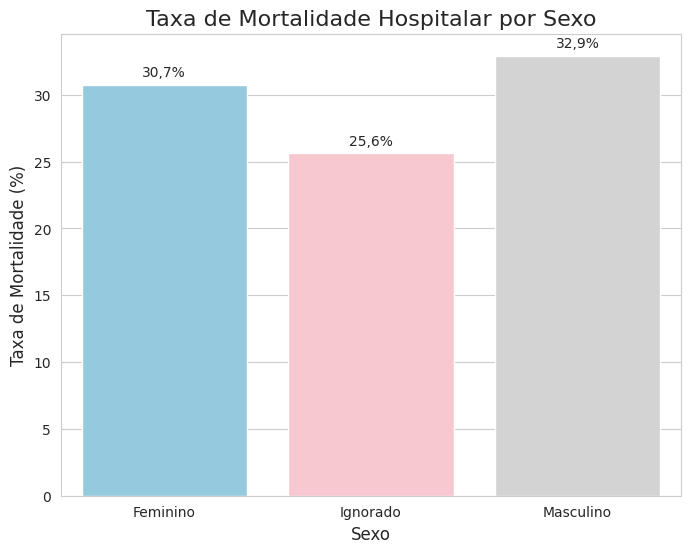

In [9]:
# --- 9: ANÁLISE POR SEXO ---

print("--- Análise de Casos Graves e Óbitos por Sexo ---")

# Agrupar por sexo, contar o total de casos e somar os óbitos
analise_sexo = df_final.groupby('CS_SEXO')['OBITO'].agg(
    Casos_Hospitalizados='count',
    Total_Obitos='sum'
)
analise_sexo['Taxa_Mortalidade_%'] = (analise_sexo['Total_Obitos'] / analise_sexo['Casos_Hospitalizados']) * 100
analise_sexo.index = analise_sexo.index.map({'M': 'Masculino', 'F': 'Feminino', 'I': 'Ignorado'})

print("\n--- Tabela: Distribuição por Sexo ---")
display(analise_sexo)

# --- Gráfico: Taxa de Mortalidade por Sexo ---
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
grafico_sexo = sns.barplot(
    x=analise_sexo.index,
    y=analise_sexo['Taxa_Mortalidade_%'],
    palette=['skyblue', 'pink', 'lightgray']
)
plt.title('Taxa de Mortalidade Hospitalar por Sexo', fontsize=16)
plt.xlabel('Sexo', fontsize=12)
plt.ylabel('Taxa de Mortalidade (%)', fontsize=12)
for p in grafico_sexo.patches:
    grafico_sexo.annotate(f'{p.get_height():.1f}%'.replace('.', ','),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.show()

 ## **10. Análise por Faixa Etária**
**Descrição:**

- A idade foi, indiscutivelmente, o maior fator de risco da COVID-19. Nesta análise, vamos comprovar isso com dados. Criaremos faixas etárias a partir da coluna IDADE e calcularemos a taxa de mortalidade para cada grupo. O gráfico resultante é uma das visualizações mais impactantes do projeto, mostrando claramente o aumento do risco com a idade.


--- Análise de Casos Graves e Óbitos por Faixa Etária ---

--- Tabela: Distribuição por Faixa Etária ---


/tmp/ipython-input-99828811.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analise_idade = df_final.groupby('FAIXA_ETARIA')['OBITO'].agg(


,Casos_Hospitalizados,Total_Obitos,Taxa_Mortalidade_%
FAIXA_ETARIA,,,
0-9,6522,272,4.170500
10-19,6372,543,8.521657
20-29,27028,2228,8.243303
30-39,66703,6906,10.353357
40-49,98598,14912,15.124039
50-59,128592,29238,22.737029
60-69,149109,52817,35.421738
70-79,128810,60681,47.108920
80+,105190,62384,59.306018


/tmp/ipython-input-99828811.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico_idade = sns.barplot(x=analise_idade.index, y=analise_idade['Taxa_Mortalidade_%'], palette='Reds')


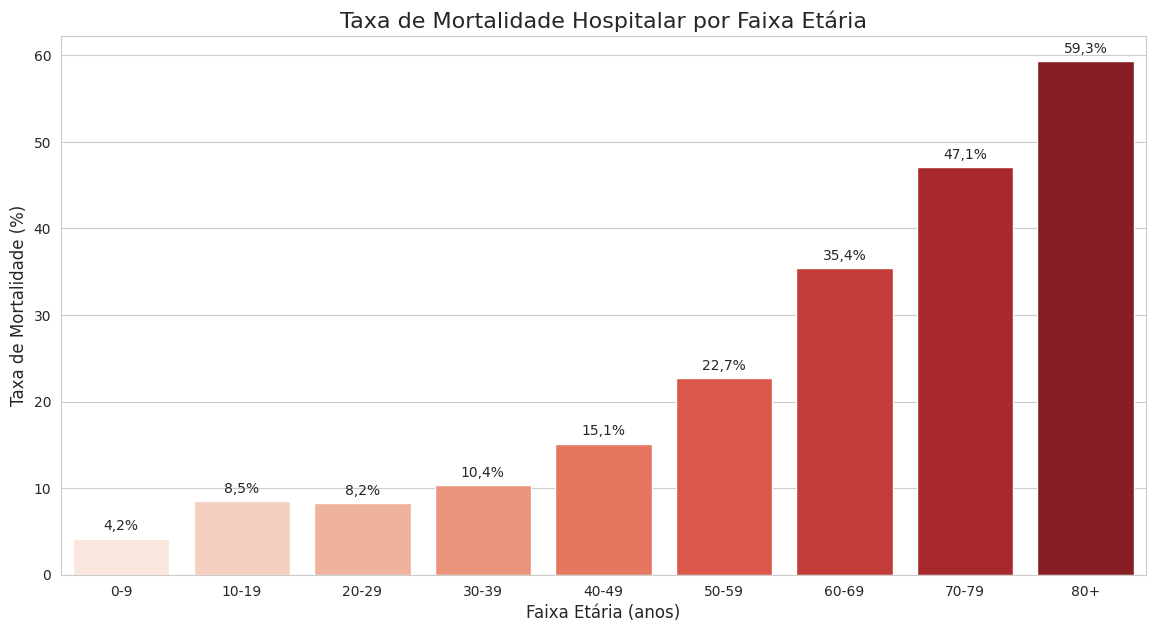

In [10]:
# --- 10: ANÁLISE POR FAIXA ETÁRIA ---

print("\n--- Análise de Casos Graves e Óbitos por Faixa Etária ---")

bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 120]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
df_final['FAIXA_ETARIA'] = pd.cut(df_final['IDADE'], bins=bins, labels=labels, right=True)

analise_idade = df_final.groupby('FAIXA_ETARIA')['OBITO'].agg(
    Casos_Hospitalizados='count',
    Total_Obitos='sum'
)
analise_idade['Taxa_Mortalidade_%'] = (analise_idade['Total_Obitos'] / analise_idade['Casos_Hospitalizados']) * 100

print("\n--- Tabela: Distribuição por Faixa Etária ---")
display(analise_idade)

# --- Gráfico: Taxa de Mortalidade por Faixa Etária ---
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
grafico_idade = sns.barplot(x=analise_idade.index, y=analise_idade['Taxa_Mortalidade_%'], palette='Reds')
plt.title('Taxa de Mortalidade Hospitalar por Faixa Etária', fontsize=16)
plt.xlabel('Faixa Etária (anos)', fontsize=12)
plt.ylabel('Taxa de Mortalidade (%)', fontsize=12)
for p in grafico_idade.patches:
    grafico_idade.annotate(f'{p.get_height():.1f}%'.replace('.', ','),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.show()

## **11: Análise Detalhada por Estado (UF)**
**Descrição:**

- Nesta etapa, vamos consolidar os dados por estado. Para cada UF, calcularemos o total de casos hospitalizados, o total de óbitos, a taxa de mortalidade hospitalar e, crucialmente, as taxas de casos e óbitos por 100 mil habitantes. Essa normalização pela população nos permitirá comparar o impacto da pandemia de forma justa entre estados de tamanhos diferentes.

In [14]:
# --- 11 ANÁLISE DETALHADA POR ESTADO (UF) ---

print("--- Análise de Casos Graves e Óbitos por Estado ---")

# Usando o DataFrame correto 'df_final'
casos_por_estado = df_final.groupby('SG_UF').size()
obitos_por_estado = df_final.groupby('SG_UF')['OBITO'].sum()

# Usar um dicionário com os dados de população do IBGE (Estimativa 2021)
populacao_estados = {
    'SP': 46649132, 'MG': 21411923, 'RJ': 17463349, 'BA': 14985284, 'PR': 11597484,
    'RS': 11466630, 'PE': 9674793, 'CE': 9240580, 'PA': 8777124, 'SC': 7338473,
    'MA': 7153262, 'GO': 7206589, 'AM': 4269995, 'ES': 4108508, 'PB': 4059905,
    'RN': 3560903, 'MT': 3567234, 'AL': 3365351, 'PI': 3289290, 'DF': 3094325,
    'MS': 2839188, 'SE': 2338474, 'RO': 1815278, 'TO': 1607363, 'AC': 906856,
    'AP': 877613, 'RR': 652713
}

# Criar o DataFrame de estados
df_estados = pd.DataFrame({
    'Casos_Hospitalizados': casos_por_estado,
    'Obitos': obitos_por_estado
})

# Adicionar a população ao DataFrame
df_estados['Populacao'] = df_estados.index.map(populacao_estados)

# Calcular as métricas finais
df_estados.dropna(subset=['Populacao'], inplace=True)
df_estados['Populacao'] = df_estados['Populacao'].astype(int)
df_estados['Taxa_Mortalidade_%'] = (df_estados['Obitos'] / df_estados['Casos_Hospitalizados']) * 100
df_estados['Casos_por_100k_hab'] = (df_estados['Casos_Hospitalizados'] / df_estados['Populacao']) * 100000
df_estados['Obitos_por_100k_hab'] = (df_estados['Obitos'] / df_estados['Populacao']) * 100000

print("\n--- Tabela Consolidada por Estado (com dados do IBGE) ---")
display(df_estados.sort_values(by='Casos_Hospitalizados', ascending=False))

--- Análise de Casos Graves e Óbitos por Estado ---

--- Tabela Consolidada por Estado (com dados do IBGE) ---


,Casos_Hospitalizados,Obitos,Populacao,Taxa_Mortalidade_%,Casos_por_100k_hab,Obitos_por_100k_hab
SG_UF,,,,,,
SP,204355,56173,46649132,27.487950,438.068172,120.415960
RJ,84805,34311,17463349,40.458699,485.617049,196.474342
MG,53810,15820,21411923,29.399740,251.308582,73.884069
PR,36453,9782,11597484,26.834554,314.318175,84.345881
RS,35469,10687,11466630,30.130537,309.323664,93.200879
PE,32502,12241,9674793,37.662298,335.945172,126.524671
CE,28332,11410,9240580,40.272483,306.604131,123.477098
BA,26607,9950,14985284,37.396174,177.554192,66.398475
MT,24501,3789,3567234,15.464675,686.834674,106.216749


## **12. Visualização dos Rankings por Estado**
**Descrição:**

- Com a tabela consolidada pronta, vamos criar três gráficos de barras para visualizar os rankings mais importantes. As visualizações nos ajudarão a identificar rapidamente os estados mais afetados, tanto em números absolutos quanto em termos proporcionais à sua população.

/tmp/ipython-input-2788480775.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  grafico_casos_uf = sns.barplot(x=top_10_casos['Casos_Hospitalizados'], y=top_10_casos.index, orient='h', palette='viridis')


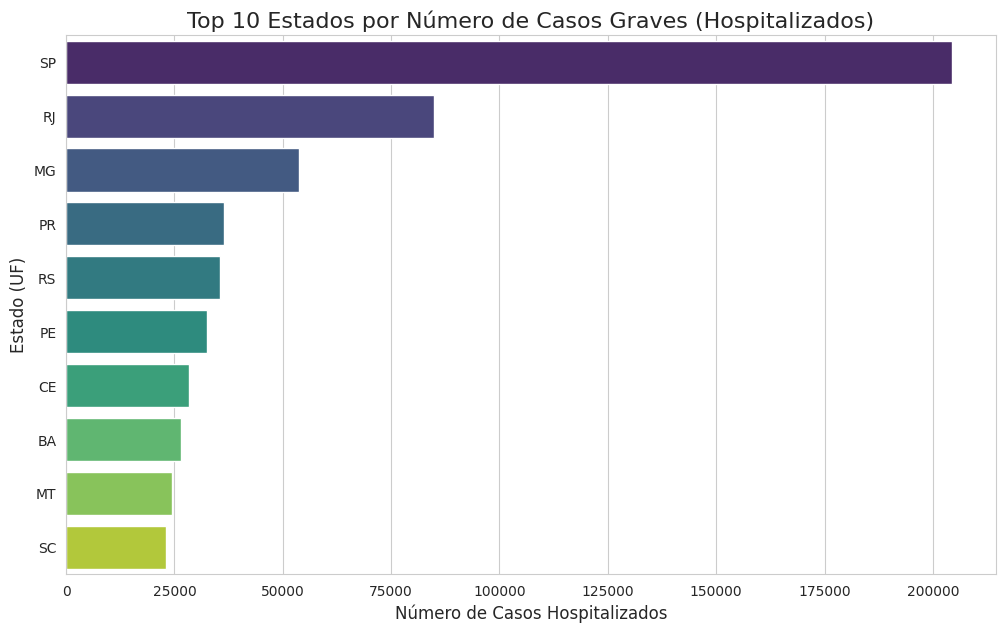

/tmp/ipython-input-2788480775.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  grafico_casos_hab_uf = sns.barplot(x=top_10_casos_hab['Casos_por_100k_hab'], y=top_10_casos_hab.index, orient='h', palette='cividis')


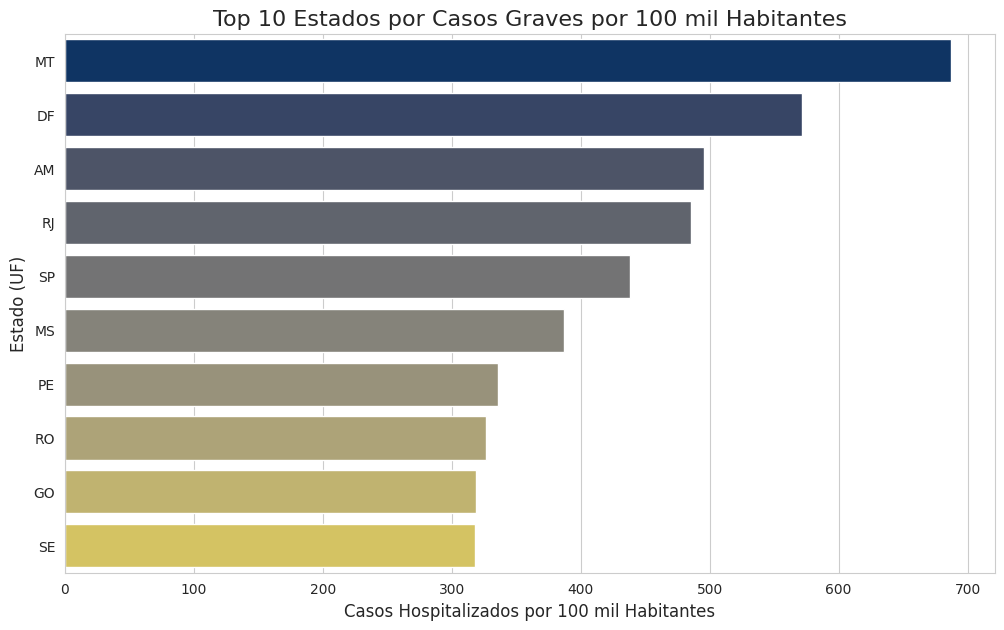

/tmp/ipython-input-2788480775.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  grafico_mortalidade_uf = sns.barplot(x=top_10_mortalidade_uf['Taxa_Mortalidade_%'], y=top_10_mortalidade_uf.index, orient='h', palette='rocket_r')


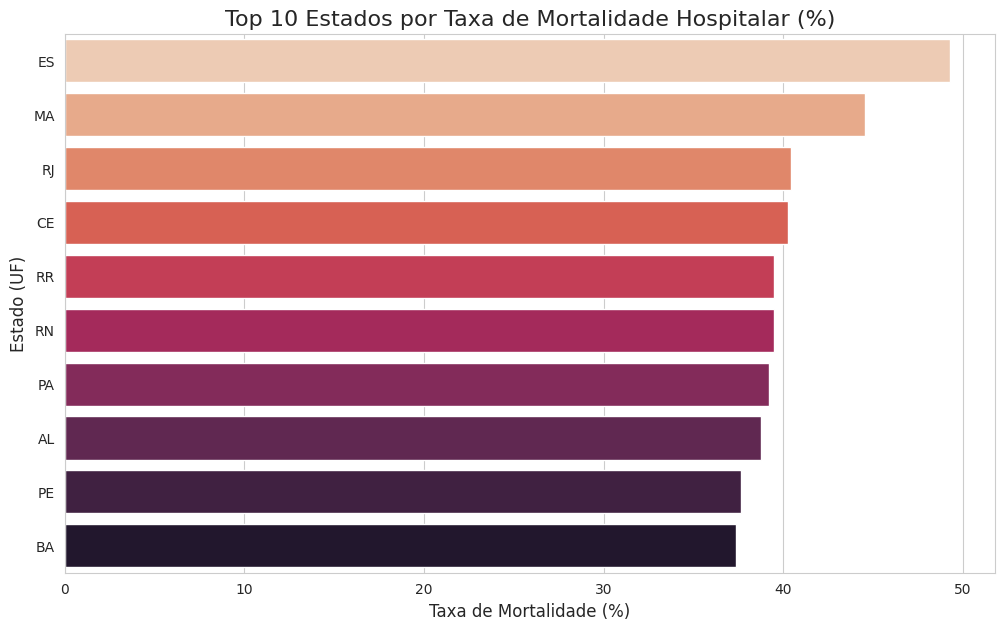

In [15]:
# --- 12: VISUALIZAÇÃO DOS RANKINGS POR ESTADO ---

# --- Gráfico 1: Top 10 Estados por Casos Hospitalizados (Números Absolutos) ---
top_10_casos = df_estados.sort_values(by='Casos_Hospitalizados', ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
grafico_casos_uf = sns.barplot(x=top_10_casos['Casos_Hospitalizados'], y=top_10_casos.index, orient='h', palette='viridis')
plt.title('Top 10 Estados por Número de Casos Graves (Hospitalizados)', fontsize=16)
plt.xlabel('Número de Casos Hospitalizados', fontsize=12)
plt.ylabel('Estado (UF)', fontsize=12)
plt.show()

# --- Gráfico 2: Top 10 Estados por Casos por 100 mil Habitantes (Comparação Justa) ---
top_10_casos_hab = df_estados.sort_values(by='Casos_por_100k_hab', ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
grafico_casos_hab_uf = sns.barplot(x=top_10_casos_hab['Casos_por_100k_hab'], y=top_10_casos_hab.index, orient='h', palette='cividis')
plt.title('Top 10 Estados por Casos Graves por 100 mil Habitantes', fontsize=16)
plt.xlabel('Casos Hospitalizados por 100 mil Habitantes', fontsize=12)
plt.ylabel('Estado (UF)', fontsize=12)
plt.show()

# --- Gráfico 3: Top 10 Estados por Taxa de Mortalidade Hospitalar ---
top_10_mortalidade_uf = df_estados.sort_values(by='Taxa_Mortalidade_%', ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
grafico_mortalidade_uf = sns.barplot(x=top_10_mortalidade_uf['Taxa_Mortalidade_%'], y=top_10_mortalidade_uf.index, orient='h', palette='rocket_r')
plt.title('Top 10 Estados por Taxa de Mortalidade Hospitalar (%)', fontsize=16)
plt.xlabel('Taxa de Mortalidade (%)', fontsize=12)
plt.ylabel('Estado (UF)', fontsize=12)
plt.show()

## **13. Análise por Macro-Região**
**Descrição:**

- Vamos agrupar os 27 estados (incluindo o DF) em suas respectivas macro-regiões. Em seguida, calcularemos as métricas consolidadas para cada uma delas e criaremos gráficos para comparar o impacto da pandemia em cada região do país de forma justa, utilizando as taxas por 100 mil habitantes.

--- Tabela Consolidada por Macro-Região ---


,Casos_Hospitalizados,Obitos,Populacao,Taxa_Mortalidade_%,Casos_por_100k_hab,Obitos_por_100k_hab
REGIAO,,,,,,
Sudeste,351180,110353,89632912,31.423487,391.798048,123.116607
Nordeste,139558,52578,57667842,37.674659,242.003160,91.173864
Sul,94973,26790,30402587,28.208017,312.384601,88.117501
Centro-Oeste,76138,19106,16707336,25.093908,455.715980,114.356951
Norte,59104,21548,18906942,36.457769,312.604756,113.968721


/tmp/ipython-input-1705136766.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='REGIAO', y='Casos_por_100k_hab',
/tmp/ipython-input-1705136766.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='REGIAO', y='Taxa_Mortalidade_%',


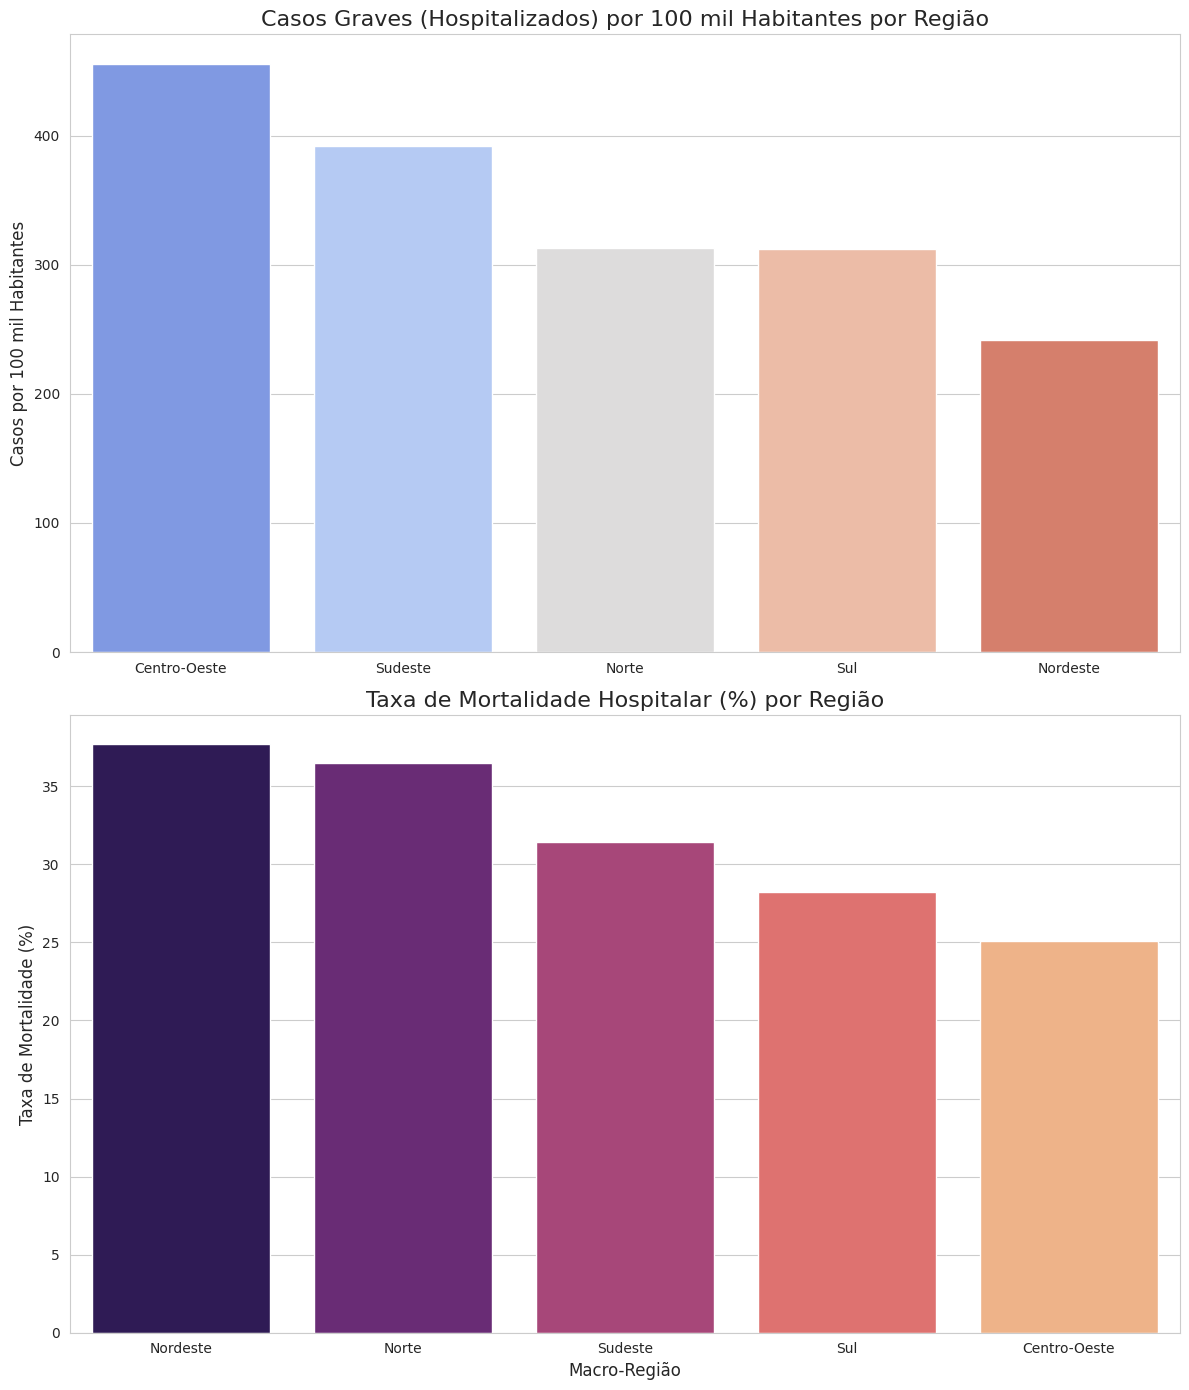

In [16]:
# --- 13: ANÁLISE POR MACRO-REGIÃO ---

# 1. Dicionário para mapear cada estado (UF) para sua respectiva região
mapa_regioes = {
    'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

# 2. Criar a nova coluna 'REGIAO' no nosso DataFrame de estados (df_estados)
df_estados['REGIAO'] = df_estados.index.map(mapa_regioes)

# 3. Agrupar por região e somar os valores (casos, óbitos e população)
df_regioes = df_estados.groupby('REGIAO')[['Casos_Hospitalizados', 'Obitos', 'Populacao']].sum()

# 4. Calcular as métricas finais para cada região
df_regioes['Taxa_Mortalidade_%'] = (df_regioes['Obitos'] / df_regioes['Casos_Hospitalizados']) * 100
df_regioes['Casos_por_100k_hab'] = (df_regioes['Casos_Hospitalizados'] / df_regioes['Populacao']) * 100000
df_regioes['Obitos_por_100k_hab'] = (df_regioes['Obitos'] / df_regioes['Populacao']) * 100000

print("--- Tabela Consolidada por Macro-Região ---")
display(df_regioes.sort_values(by='Casos_Hospitalizados', ascending=False))


# --- Gráfico: Comparativo entre as Macro-Regiões ---
# Usamos .reset_index() para transformar o índice 'REGIAO' em uma coluna para o gráfico
df_regioes_grafico = df_regioes.reset_index()

# Criamos 2 subplots para visualizar métricas diferentes de forma clara
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 14))
sns.set_style("whitegrid")

# Gráfico 1: Casos por 100k Habitantes
sns.barplot(x='REGIAO', y='Casos_por_100k_hab',
            data=df_regioes_grafico.sort_values(by='Casos_por_100k_hab', ascending=False),
            ax=ax1, palette='coolwarm')
ax1.set_title('Casos Graves (Hospitalizados) por 100 mil Habitantes por Região', fontsize=16)
ax1.set_xlabel('')
ax1.set_ylabel('Casos por 100 mil Habitantes', fontsize=12)

# Gráfico 2: Taxa de Mortalidade Hospitalar
sns.barplot(x='REGIAO', y='Taxa_Mortalidade_%',
            data=df_regioes_grafico.sort_values(by='Taxa_Mortalidade_%', ascending=False),
            ax=ax2, palette='magma')
ax2.set_title('Taxa de Mortalidade Hospitalar (%) por Região', fontsize=16)
ax2.set_xlabel('Macro-Região', fontsize=12)
ax2.set_ylabel('Taxa de Mortalidade (%)', fontsize=12)

plt.tight_layout()
plt.show()

## **14. Análise Temporal - As Ondas da Pandemia no Brasil**
**Descrição:**

- Vamos criar os gráficos que mostram a evolução diária de casos graves (hospitalizações) e de óbitos ao longo de todo o período dos nossos dados. Usaremos a média móvel de 7 dias, nossa técnica já consagrada, para suavizar as linhas e revelar as ondas da pandemia de forma clara e precisa.

Preparando os dados para a análise temporal final...
Dados preparados. Gerando os gráficos finais...


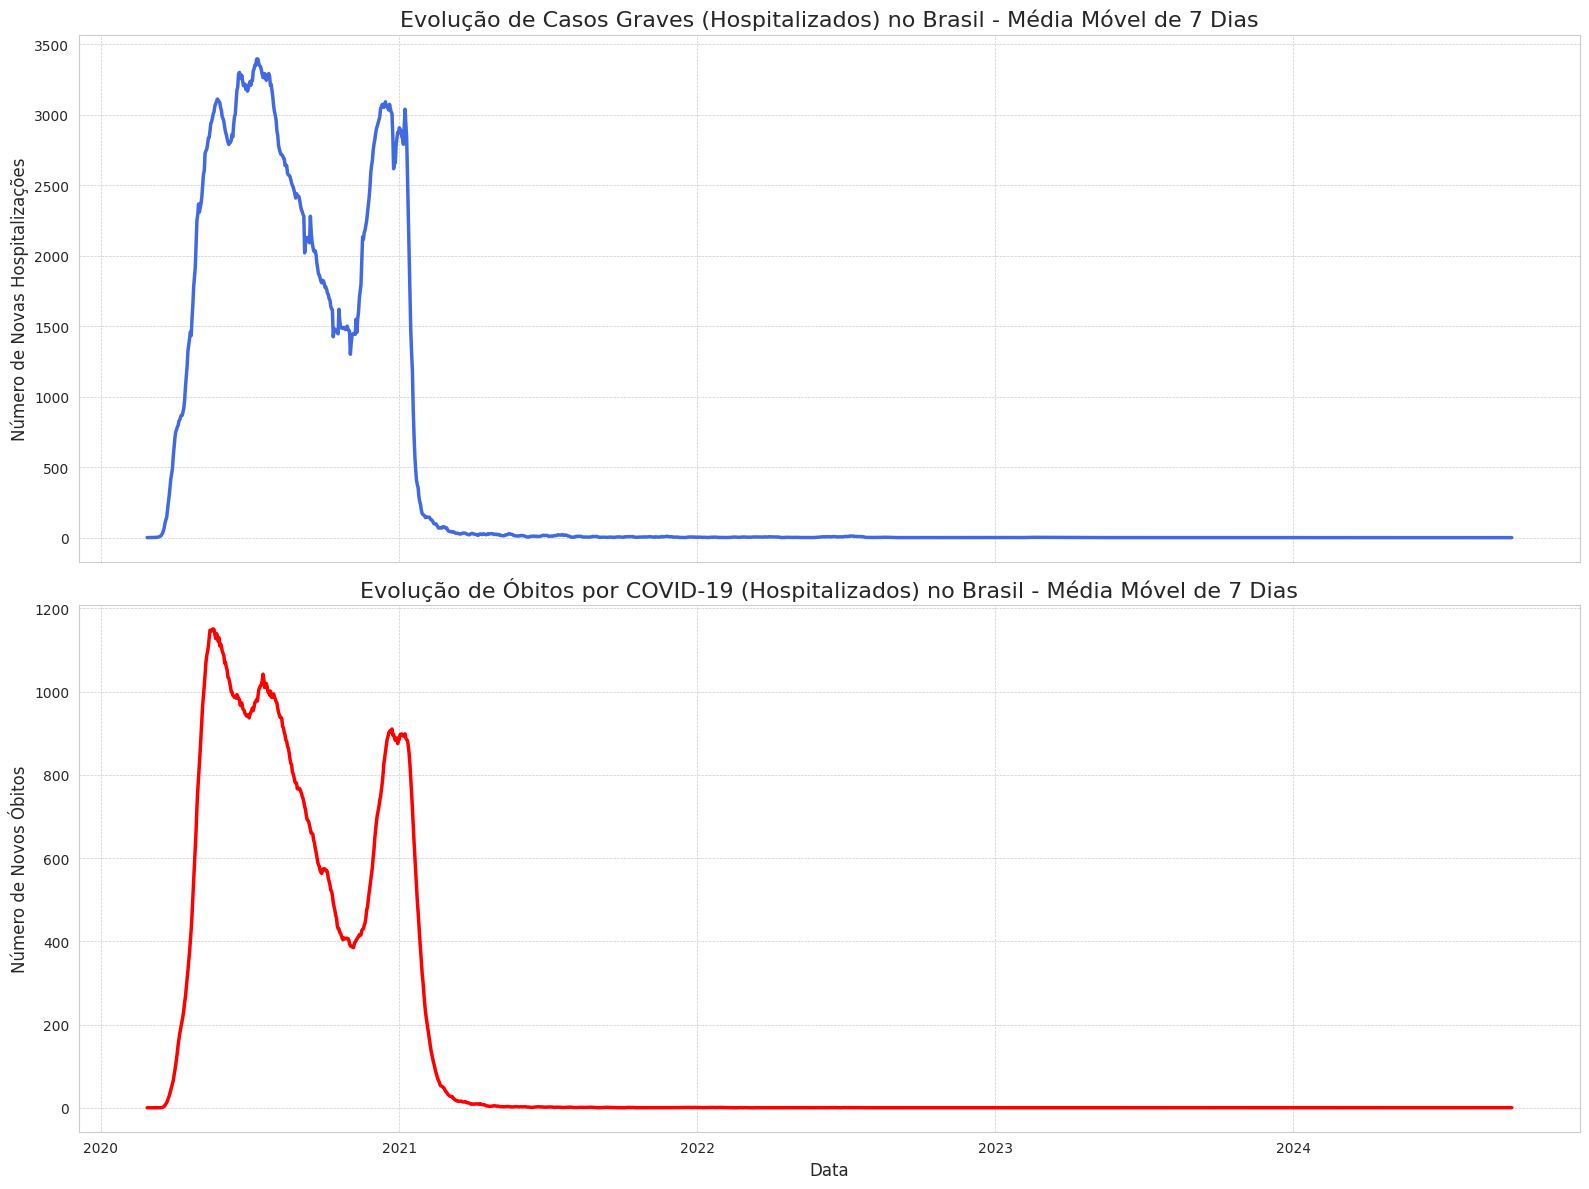

In [18]:
# --- CÉLULA 14: ANÁLISE TEMPORAL - AS ONDAS DA PANDEMIA NO BRASIL ---

print("Preparando os dados para a análise temporal final...")

# Agrupar por data de notificação para contar os casos diários
casos_diarios = df_final.groupby('DT_NOTIFIC').size().rename('casos_novos')

# Agrupar por data de evolução para contar os óbitos diários
obitos_diarios = df_final[df_final['OBITO'] == 1].groupby('DT_EVOLUCA').size().rename('obitos_novos')

# Combinar as duas séries em um único DataFrame temporal, preenchendo dias sem registro com 0
df_temporal_br = pd.concat([casos_diarios, obitos_diarios], axis=1).fillna(0)

# Calcular a média móvel de 7 dias para ambos
df_temporal_br['casos_media_movel'] = df_temporal_br['casos_novos'].rolling(window=7).mean()
df_temporal_br['obitos_media_movel'] = df_temporal_br['obitos_novos'].rolling(window=7).mean()

print("Dados preparados. Gerando os gráficos finais...")

# --- Visualização Final: Duas Curvas (Casos e Óbitos) ---
# Criamos uma figura com 2 gráficos (um em cima do outro) para comparar melhor
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True)
sns.set_style("whitegrid")

# Gráfico de Casos Graves (Hospitalizados)
ax1.plot(df_temporal_br.index, df_temporal_br['casos_media_movel'], color='royalblue', linewidth=2.5)
ax1.set_title('Evolução de Casos Graves (Hospitalizados) no Brasil - Média Móvel de 7 Dias', fontsize=16)
ax1.set_ylabel('Número de Novas Hospitalizações', fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Gráfico de Óbitos
ax2.plot(df_temporal_br.index, df_temporal_br['obitos_media_movel'], color='red', linewidth=2.5)
ax2.set_title('Evolução de Óbitos por COVID-19 (Hospitalizados) no Brasil - Média Móvel de 7 Dias', fontsize=16)
ax2.set_ylabel('Número de Novos Óbitos', fontsize=12)
ax2.set_xlabel('Data', fontsize=12)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout() # Ajusta o espaçamento para que os títulos não se sobreponham
plt.show()

## **Relatório e Conclusão Final do Projeto**

> **A pandemia de COVID-19 representou um desafio sem precedentes para os sistemas de saúde em todo o mundo. No Brasil, a vasta extensão territorial e as desigualdades regionais criaram um cenário complexo e multifacetado. Através da análise de mais de 1.2 milhão de registros de casos graves (hospitalizados) de COVID-19, provenientes da base de dados oficial de Síndrome Respiratória Aguda Grave (SRAG) do Ministério da Saúde, este projeto traçou um panorama detalhado do impacto da doença no país.**


✅**Principais Descobertas:**

- A análise revelou que o impacto da pandemia não foi homogêneo. Geograficamente, estados mais populosos como São Paulo lideraram em números absolutos de hospitalizações e óbitos. No entanto, uma análise normalizada pela população mostrou que o impacto proporcional foi mais severo em outras regiões, com o Centro-Oeste e o Sudeste apresentando as maiores taxas de casos graves por 100 mil habitantes. - A taxa de mortalidade entre os pacientes hospitalizados também variou significativamente, com estados como o Rio de Janeiro apresentando uma das maiores letalidades, um possível indicador de maior pressão sobre o sistema de saúde local.

- O perfil demográfico das vítimas de casos graves demonstrou um padrão de risco claro. Embora o número de hospitalizações tenha sido similar entre os sexos, a taxa de mortalidade foi consistentemente maior entre os homens. O fator mais determinante, contudo, foi a idade: a análise por faixa etária mostrou um aumento exponencial na letalidade a cada década de vida, ultrapassando os 50% para pacientes com mais de 70 anos.

- Finalmente, a análise temporal permitiu visualizar a cronologia das ondas pandêmicas no Brasil. Identificamos claramente três grandes ondas de hospitalizações: a primeira em meados de 2020, a segunda, mais longa e letal, no primeiro semestre de 2021 (associada à variante Gamma), e a terceira no início de 2022, que, embora tenha apresentado um pico de hospitalizações muito alto (associado à variante Ômicron), demonstrou uma letalidade hospitalar inferior à da onda anterior.



## **Conclusão:**

> Este projeto ilustra o poder da análise de dados para transformar milhões de registros brutos em uma narrativa coerente e cheia de insights. A combinação de técnicas de limpeza, enriquecimento, análise estatística e visualização permitiu desvendar os padrões geográficos, demográficos e temporais da pandemia no Brasil, oferecendo uma visão detalhada e baseada em evidências de um dos maiores desafios de saúde pública da nossa história.